In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.layers import Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [2]:
num_classes = 10
batch_size = 1000
epochs = 12

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# input image dimensions
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

('x_train shape:', (60000, 28, 28, 1))
(60000, 'train samples')
(10000, 'test samples')


In [3]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [4]:
from utils import sparse_sample_multinomial
from keras.metrics import sparse_categorical_accuracy
from keras.losses import sparse_categorical_crossentropy
import numpy as np

def my_sparse_categorical_accuracy(y_true, y_pred):
    return K.cast(K.equal(y_true, K.cast(y_pred, K.floatx())), K.floatx())

def reinforce_loss(y_true, y_pred):
    y_samp = sparse_sample_multinomial(y_pred)[:, None]
    rewards = my_sparse_categorical_accuracy(y_true, y_samp)
    baselines = my_sparse_categorical_accuracy(y_true, K.argmax(y_pred, axis=-1))
    advantages = rewards - baselines
    return advantages * sparse_categorical_crossentropy(y_samp, y_pred)[:, None]
'''
def reinforce_loss(y_true, y_pred):
    y_samp = sparse_sample_multinomial(y_pred)
    rewards = sparse_categorical_accuracy(y_true, K.one_hot(y_samp, K.shape(y_pred)[-1]))
    baselines = sparse_categorical_accuracy(y_true, y_pred)
    advantages = rewards - baselines
    return advantages * sparse_categorical_crossentropy(y_samp, y_pred)
'''
model.compile(loss=reinforce_loss, optimizer=Adam(lr=0.001), metrics=['sparse_categorical_accuracy'])

In [5]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 16s - loss: 0.0436 - sparse_categorical_accuracy: 0.7071 - val_loss: 0.0149 - val_sparse_categorical_accuracy: 0.9117
Epoch 2/12
60000/60000 [==============================] - 14s - loss: 0.0186 - sparse_categorical_accuracy: 0.8921 - val_loss: 0.0107 - val_sparse_categorical_accuracy: 0.9444
Epoch 3/12
60000/60000 [==============================] - 14s - loss: 0.0155 - sparse_categorical_accuracy: 0.9324 - val_loss: 0.0080 - val_sparse_categorical_accuracy: 0.9620
Epoch 4/12
60000/60000 [==============================] - 14s - loss: 0.0109 - sparse_categorical_accuracy: 0.9483 - val_loss: 0.0069 - val_sparse_categorical_accuracy: 0.9693
Epoch 5/12
60000/60000 [==============================] - 14s - loss: 0.0101 - sparse_categorical_accuracy: 0.9557 - val_loss: 0.0056 - val_sparse_categorical_accuracy: 0.9749
Epoch 6/12
60000/60000 [==============================] - 14s - loss: 

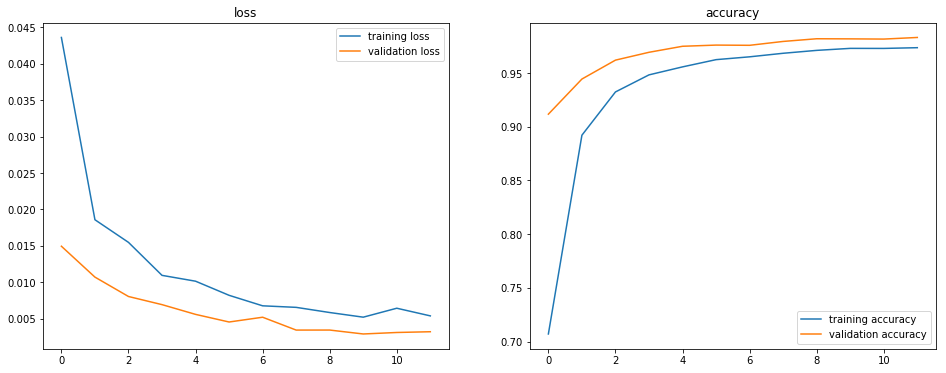

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.title('loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.legend(['training accuracy', 'validation accuracy'])
plt.title('accuracy')

In [7]:
score = model.evaluate(x_test, y_test, verbose=0)
#print('Test loss:', score[0])
print('Test accuracy:', score[1])

('Test accuracy:', 0.98309999999999997)
